In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.stats import qmc
import math

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/My Drive/WUR/Modeling in Systems Biology/week_5/SSB Group Project/Code + Data/Data/"

file_r1   = base_path + "core_metabolism_r1.csv"
file_r01  = base_path + "core_metabolism_r01.csv"
file_r001 = base_path + "core_metabolism_r001.csv"

data_time, PEP_mean1,  PEP_sd1,  PYR_mean1,  PYR_sd1  = np.loadtxt(file_r1,   delimiter=",", unpack=True)
data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt(file_r01,  delimiter=",", unpack=True)
data_time, PEP_mean001,PEP_sd001,PYR_mean001,PYR_sd001= np.loadtxt(file_r001, delimiter=",", unpack=True)

print("Datasets loaded: r = 1, 0.1, 0.01")

t_sim = np.linspace(0, 10, 1001)


Mounted at /content/drive
Datasets loaded: r = 1, 0.1, 0.01


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.stats import qmc
import math

First part for methods starts here

In [2]:
def ode_function(state, t, r, d, phi0):
    Glc, PEP, PYR, OAA = state

    # Energy status function: φ = max(1 − PYR, φ0)
    phi = max(1 - PYR, phi0)

    dGlc_dt = - r * phi * Glc
    dPEP_dt = r * phi * (Glc + OAA) + phi * PYR - PEP * (1 + phi + d)
    dPYR_dt = r * phi * OAA + phi * PEP - PYR * (phi + d)
    dOAA_dt = PEP - phi * OAA

    return [dGlc_dt, dPEP_dt, dPYR_dt, dOAA_dt]


In [ ]:
def ode_function(state, t, r, d, phi0):
    Glc, PEP, PYR, OAA = state

    # Energy status function: φ = max(1 − PYR, φ0)
    phi = max(1 - PYR, phi0)

    dGlc_dt = - r * phi * Glc
    dPEP_dt = r * phi * (Glc + OAA) + phi * PYR - PEP * (1 + phi + d)
    dPYR_dt = r * phi * OAA + phi * PEP - PYR * (phi + d)
    dOAA_dt = PEP - phi * OAA

    return [dGlc_dt, dPEP_dt, dPYR_dt, dOAA_dt]


In [ ]:
def score_single_dataset(OAA0, d, phi0,
                         mean_PEP, sd_PEP,
                         mean_PYR, sd_PYR,
                         r):
    """
    Scoring function. It calculates the score for each set
    of initial conditions (only changing OAA(0)) and parameters
    (only changing d and phi0).
    """
    # Initial conditions
    Glc0 = 1
    PEP0 = mean_PEP[0]
    PYR0 = mean_PYR[0]

    init = [Glc0, PEP0, PYR0, OAA0]

    # Solve ODE
    sol = odeint(ode_function, init, t_sim, args=(r, d, phi0))
    PEP_sim = sol[:,1]
    PYR_sim = sol[:,2]

    # Interpolate to match experimental time points
    PEP_interp = interp1d(t_sim, PEP_sim)(data_time)
    PYR_interp = interp1d(t_sim, PYR_sim)(data_time)

    # Weighted least squares
    score = np.sum((mean_PEP - PEP_interp)**2 / sd_PEP**2) + \
            np.sum((mean_PYR - PYR_interp)**2 / sd_PYR**2)

    return score


In [ ]:
def global_score(params):
    """
    Adding up the scores the model for the same parameter set but
    with differing r values. In other words, the model needs to be
    good for all r values.

    params = [OAA0, log10(d), phi0]
    """

    OAA0, logd, phi0 = params
    d = 10**logd

    total = 0

    # r = 1
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean1, PEP_sd1,
        PYR_mean1, PYR_sd1,
        r=1
    )

    # r = 0.1
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean01, PEP_sd01,
        PYR_mean01, PYR_sd01,
        r=0.1
    )

    # r = 0.01
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean001, PEP_sd001,
        PYR_mean001, PYR_sd001,
        r=0.01
    )

    return total


In [ ]:
def print_parameters(title, params, score):
    """
    Writing down the best found initial condition and parameter set.
    """
    OAA0 = params[0]
    logd = params[1]
    phi0 = params[2]
    d = 10**logd

    print(f"\n===== {title} =====")
    print(f"OAA(0) = {OAA0:.6f}  mM")
    print(f"d      = {d:.6e}  h^-1  (log10(d) = {logd:.6f})")
    print(f"phi0   = {phi0:.6f}")
    print(f"Score  = {score:.3f}")


In [ ]:
sampler = qmc.LatinHypercube(d=3)
N = 2000
raw = sampler.random(N)

# Bounds:
# OAA0 ∈ [0, 10]
# log10(d) ∈ [-9, -6]
# phi0 ∈ [0, 1]

OAA_vals  = 0   + raw[:,0] * (10 - 0)
logd_vals = -9  + raw[:,1] * (-6 + 9)
phi_vals  = 0   + raw[:,2] * (1 - 0)

samples = np.column_stack([OAA_vals, logd_vals, phi_vals])

best_score = np.inf
best_params = None

for i, ps in enumerate(samples):
    score = global_score(ps)

    if score < best_score:
        best_score = score
        best_params = ps

    if i % 200 == 0:
        print(f"Checked {i}/{N} samples. Current best score = {best_score:.2f}")

print_parameters("COARSE LHS BEST PARAMETERS", best_params, best_score)


Checked 0/2000 samples. Current best score = 3648320.89
Checked 200/2000 samples. Current best score = 400053.18
Checked 400/2000 samples. Current best score = 400053.18
Checked 600/2000 samples. Current best score = 400053.18
Checked 800/2000 samples. Current best score = 400053.18
Checked 1000/2000 samples. Current best score = 400026.16
Checked 1200/2000 samples. Current best score = 400026.16
Checked 1400/2000 samples. Current best score = 400026.16
Checked 1600/2000 samples. Current best score = 400026.16
Checked 1800/2000 samples. Current best score = 400026.16

===== COARSE LHS BEST PARAMETERS =====
OAA(0) = 1.111039  mM
d      = 1.611829e-09  h^-1  (log10(d) = -8.792681)
phi0   = 0.132068
Score  = 400026.155


In [ ]:
# Set initial parameter set guess
best_OAA, best_logd, best_phi = best_params

# Build a narrower search grid around the coarse best point
# Set bounds to be a specific value different from the initial (best) parameter set guess
OAA_grid  = np.linspace(max(0,  best_OAA  - 1), min(10, best_OAA  + 1), 20)
logd_grid = np.linspace(best_logd - 0.3, best_logd + 0.3, 20)
phi_grid  = np.linspace(max(0,  best_phi  - 0.1), min(1,  best_phi  + 0.1), 20)

fine_samples = np.array(np.meshgrid(OAA_grid, logd_grid, phi_grid)).T.reshape(-1,3)

best_score_fine = np.inf
best_params_fine = None

for ps in fine_samples:
    score = global_score(ps)
    if score < best_score_fine:
        best_score_fine = score
        best_params_fine = ps

print_parameters("FINAL BEST PARAMETERS", best_params_fine, best_score_fine)



===== FINAL BEST PARAMETERS =====
OAA(0) = 1.163670  mM
d      = 8.078280e-10  h^-1  (log10(d) = -9.092681)
phi0   = 0.126805
Score  = 400114.813


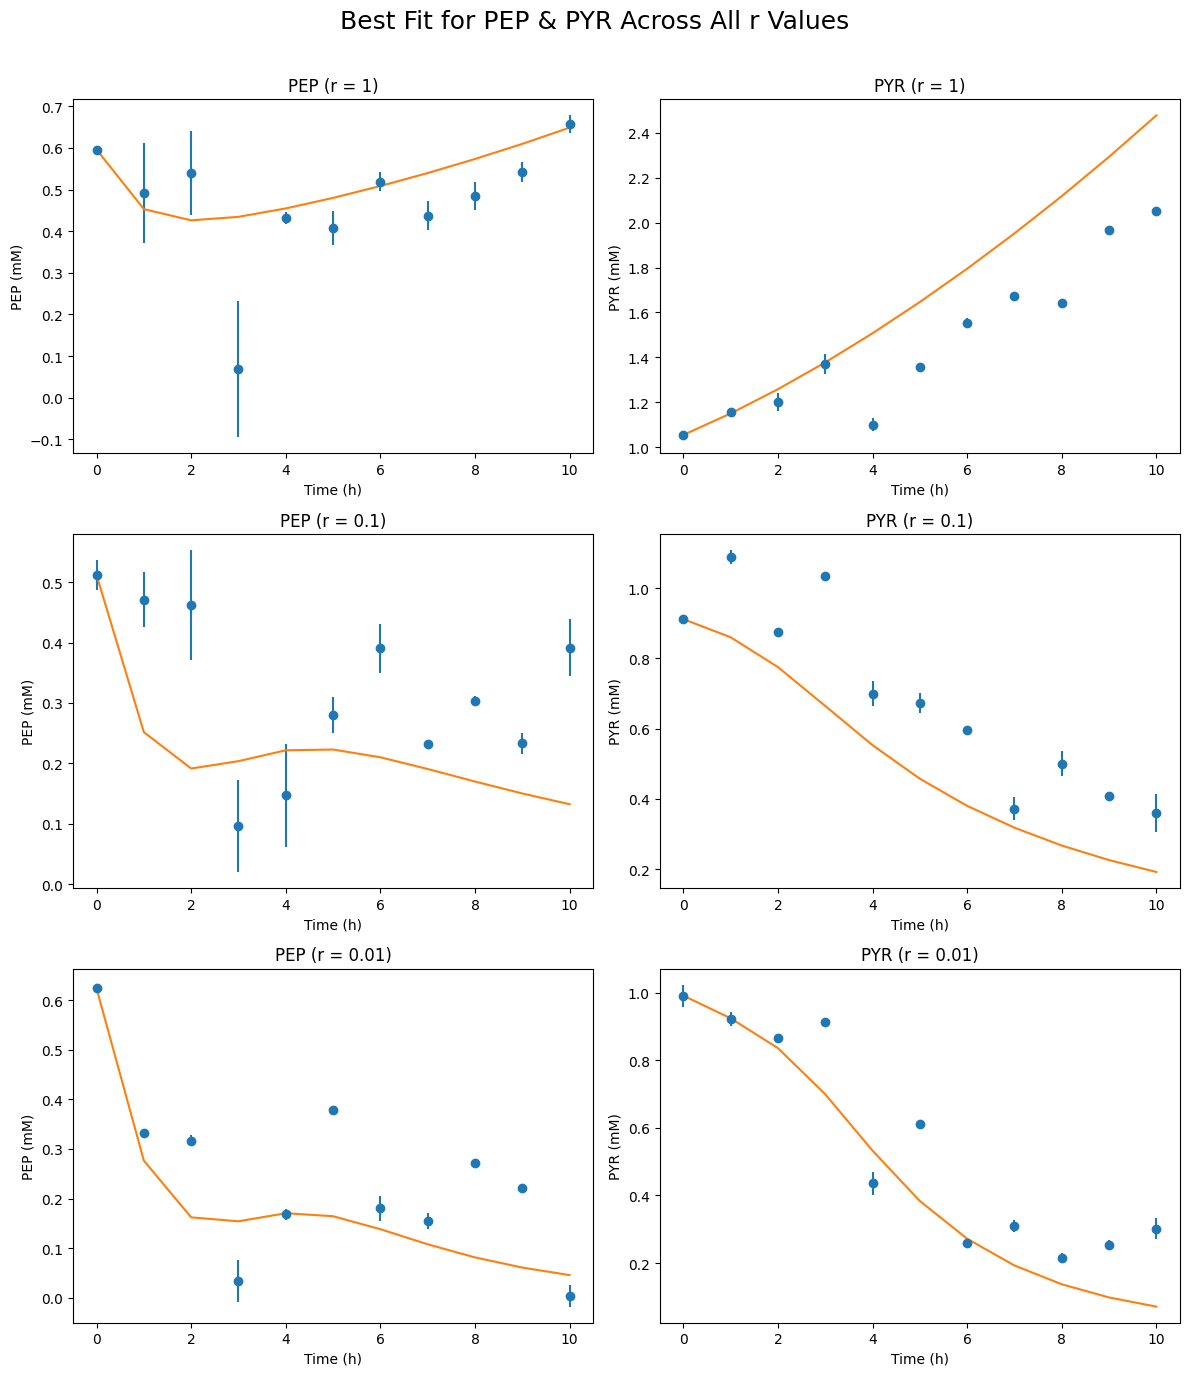

Saved figure as combined_best_fit.jpg


In [ ]:
def simulate(best_params, r):
    OAA0, logd, phi0 = best_params
    d = 10**logd

    # initial values from each dataset
    if r == 1:
        PEP0 = PEP_mean1[0]
        PYR0 = PYR_mean1[0]
    elif r == 0.1:
        PEP0 = PEP_mean01[0]
        PYR0 = PYR_mean01[0]
    else:
        PEP0 = PEP_mean001[0]
        PYR0 = PYR_mean001[0]

    init = [1, PEP0, PYR0, OAA0]
    sol = odeint(ode_function, init, t_sim, args=(r, d, phi0))
    return sol


fig, axs = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle("Best Fit for PEP & PYR Across All r Values", fontsize=18)

plot_settings = [
    (1,    PEP_mean1,  PEP_sd1,  PYR_mean1,  PYR_sd1,  "r = 1"),
    (0.1,  PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01, "r = 0.1"),
    (0.01, PEP_mean001,PEP_sd001,PYR_mean001,PYR_sd001,"r = 0.01")
]

for idx, (r, mean_PEP, sd_PEP, mean_PYR, sd_PYR, title_text) in enumerate(plot_settings):

    sol = simulate(best_params_fine, r)
    PEP_sim = sol[:,1]
    PYR_sim = sol[:,2]

    PEP_interp = interp1d(t_sim, PEP_sim)(data_time)
    PYR_interp = interp1d(t_sim, PYR_sim)(data_time)

    ax1 = axs[idx, 0]
    ax1.errorbar(data_time, mean_PEP, yerr=sd_PEP, fmt='o')
    ax1.plot(data_time, PEP_interp, '-')
    ax1.set_title(f"PEP ({title_text})")
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel("PEP (mM)")

    ax2 = axs[idx, 1]
    ax2.errorbar(data_time, mean_PYR, yerr=sd_PYR, fmt='o')
    ax2.plot(data_time, PYR_interp, '-')
    ax2.set_title(f"PYR ({title_text})")
    ax2.set_xlabel("Time (h)")
    ax2.set_ylabel("PYR (mM)")

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save as JPEG
plt.savefig("combined_best_fit.jpg", dpi=300)
plt.show()

print("Saved figure as combined_best_fit.jpg")


End of first part

Second part starts here

## Creating the simplified model

In [ ]:
def simplified_model_1_PYR(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = 1 - PYR

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def simplified_model_phi0(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = phi0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def simplified_model(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = np.maximum(1 - PYR, phi0)

    dGlc_dt = 0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

*κείμενο σε πλάγια γραφή*### Nullclines function

In [ ]:
def nullclines(ode, pars, xlim, ylim, labels = ['Nullcline x','Nullcline y'], npointsx = 100, npointsy = 100):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)
    dxdt = dXdt[0]
    dydt = dXdt[1]

    C = plt.contour(X,Y,dxdt, levels = [0], colors = ['cyan'])
    plt.plot([],[],color = 'cyan',label = labels[0])

    C = plt.contour(X,Y,dydt, levels = [0], colors = ['red'], linestyles = ['--'])
    plt.plot([],[],color = 'red', linestyle = '--', label = labels[1])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

### Phase plane function

In [ ]:
def pplane(ode, pars, xlim, ylim, npointsx = 13, npointsy = 13, rescale_arrows = True):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)

    U = np.copy(dXdt[0])
    V = np.copy(dXdt[1])
    if rescale_arrows:
        length = np.sqrt(U**2 + V**2)
        with np.errstate(divide='ignore', invalid='ignore'):
            U /= length
            V /= length

    plt.quiver(X,Y,U,V, angles = 'xy', scale_units = 'xy', pivot = 'mid')

### Plotting the model

In [ ]:
OAA0_fit = 1.011495 # mM
d_fit      = 1.084762e-09 # h^-1  (log10(d) = -8.964665)
phi0_fit   = 0.136305 # mM
Score  = 400059.278

In [ ]:
r1 = 1
r01 = 0.1
r001 = 0.01
parameters_fitted_r1 = [r1, d_fit, phi0_fit]
parameters_fitted_r01 = [r01, d_fit, phi0_fit]
parameters_fitted_r001 = [r001, d_fit, phi0_fit]

## Models for r = 1



### Model for phi0 (so phi0 > 1 - PYR) (when PYR > 1 only this function applies)

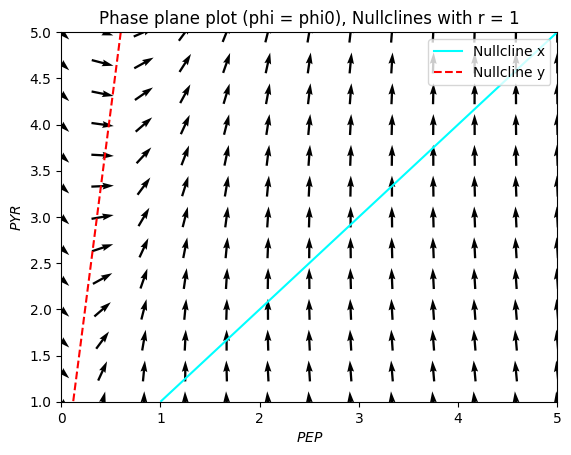

In [ ]:
xlim = (0, 5)
ylim = (1, 5)

plt.clf()
nullclines(simplified_model_phi0, parameters_fitted_r1, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r1, xlim, ylim)

plt.title(f"Phase plane plot (phi = phi0), Nullclines with r = {r1}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

### Model for 1 - PYR (so phi0 < 1 - PYR) (so only when PYR < 1 (or PYR == 1?))

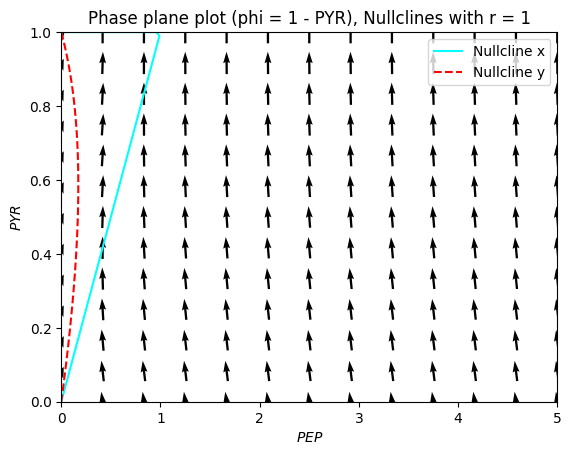

In [ ]:
xlim = (0, 5)
ylim = (0, 1)

plt.clf()
nullclines(simplified_model_1_PYR, parameters_fitted_r1, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r1, xlim, ylim)

plt.title(f"Phase plane plot (phi = 1 - PYR), Nullclines with r = {r1}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

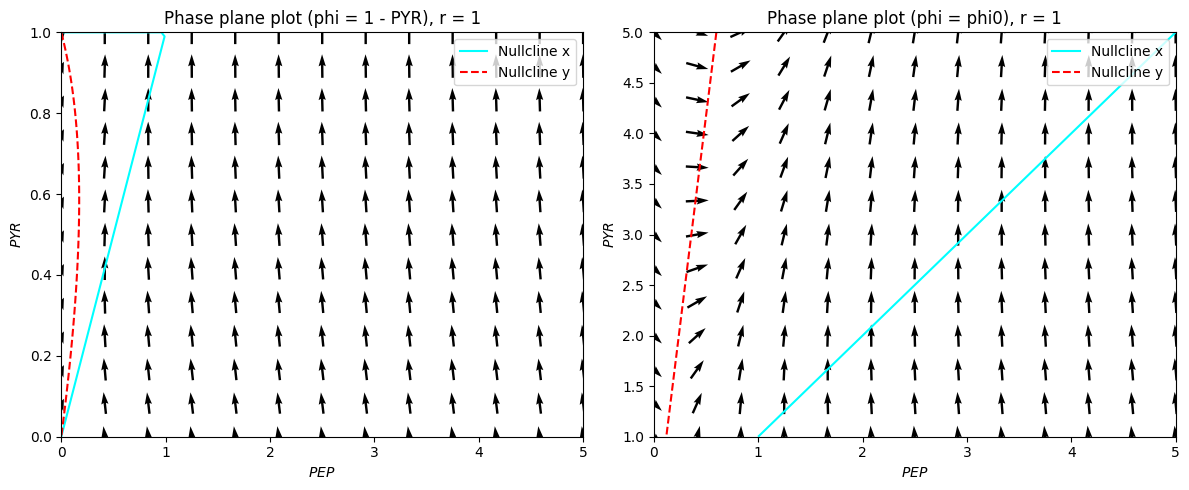

In [ ]:
import matplotlib.pyplot as plt

# Define ranges for both plots
xlim1 = (0, 5)
ylim1 = (0, 1)

xlim2 = (0, 5)
ylim2 = (1, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---------------------------
# Plot 1 — phi = 1 - PYR
# ---------------------------
ax = axes[0]
plt.sca(ax)  # set current axis

nullclines(simplified_model_1_PYR, parameters_fitted_r1, xlim1, ylim1)
pplane(simplified_model_1_PYR, parameters_fitted_r1, xlim1, ylim1)

ax.set_title(f"Phase plane plot (phi = 1 - PYR), r = {r1}")
ax.set_xlabel('$PEP$')
ax.set_ylabel('$PYR$')
ax.set_xlim(xlim1)
ax.set_ylim(ylim1)
ax.legend()

# ---------------------------
# Plot 2 — phi = phi0
# ---------------------------
ax = axes[2-1]  # or axes[1]
plt.sca(ax)

nullclines(simplified_model_phi0, parameters_fitted_r1, xlim2, ylim2)
pplane(simplified_model_phi0, parameters_fitted_r1, xlim2, ylim2)

ax.set_title(f"Phase plane plot (phi = phi0), r = {r1}")
ax.set_xlabel('$PEP$')
ax.set_ylabel('$PYR$')
ax.set_xlim(xlim2)
ax.set_ylim(ylim2)
ax.legend()

plt.tight_layout()
plt.show()

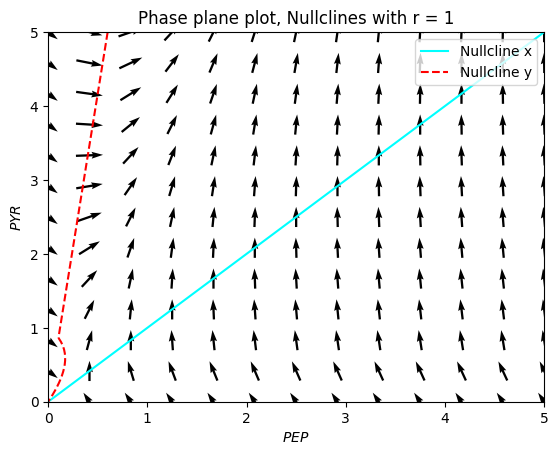

In [ ]:
xlim = (0, 5)
ylim = (0, 5)

plt.clf()
nullclines(simplified_model, parameters_fitted_r1, xlim, ylim)
pplane(simplified_model, parameters_fitted_r1, xlim, ylim)

plt.title(f"Phase plane plot, Nullclines with r = {r1}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

## Models for r = 0.1

### Model for phi0 (so phi0 > 1 - PYR) (when PYR > 1 only this function applies)

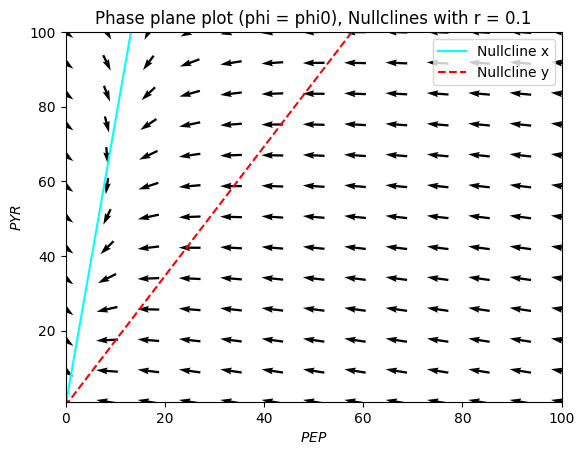

In [ ]:
xlim = (0, 100)
ylim = (1, 100)

plt.clf()
nullclines(simplified_model_phi0, parameters_fitted_r01, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r01, xlim, ylim)

plt.title(f"Phase plane plot (phi = phi0), Nullclines with r = {r01}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

### Model for 1 - PYR (so phi0 < 1 - PYR) (so only when PYR < 1 (or PYR == 1?))

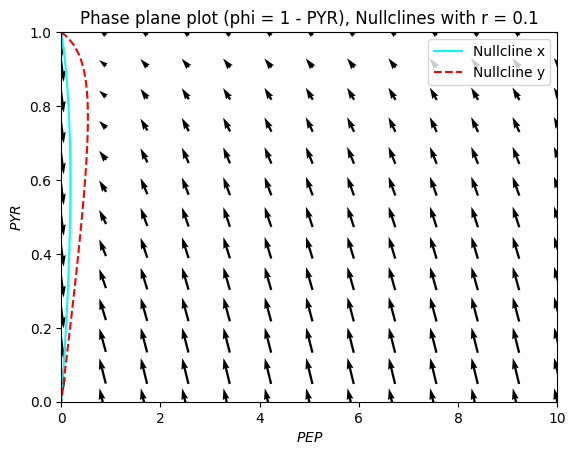

In [ ]:
xlim = (0, 10)
ylim = (0, 1)

plt.clf()
nullclines(simplified_model_1_PYR, parameters_fitted_r01, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r01, xlim, ylim)

plt.title(f"Phase plane plot (phi = 1 - PYR), Nullclines with r = {r01}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

## Models for r = 0.01

### Model for phi0 (so phi0 > 1 - PYR) (when PYR > 1 only this function applies)

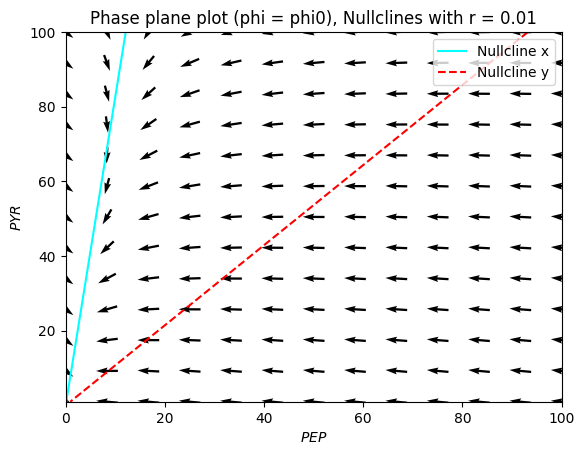

In [ ]:
xlim = (0, 100)
ylim = (1, 100)

plt.clf()
nullclines(simplified_model_phi0, parameters_fitted_r001, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r001, xlim, ylim)

plt.title(f"Phase plane plot (phi = phi0), Nullclines with r = {r001}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

### Model for 1 - PYR (so phi0 < 1 - PYR) (so only when PYR < 1 (or PYR == 1?))

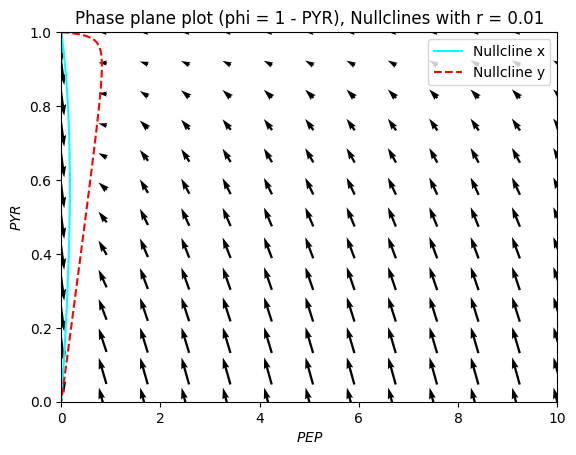

In [ ]:
xlim = (0, 10)
ylim = (0, 1)

plt.clf()
nullclines(simplified_model_1_PYR, parameters_fitted_r001, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r001, xlim, ylim)

plt.title(f"Phase plane plot (phi = 1 - PYR), Nullclines with r = {r001}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

End of second part

Start of third part

## Extra

AFTER SIMPLYFYING THE MODEL WE GET:

In [ ]:
OAA0_fit   = 1.011495  # mM (unused in 2D model, but ok to keep)
d_fit      = 1.084762e-09  # h^-1
phi0_fit   = 0.136305      # baseline from Task 1
r1 = 1
r01 = 0.1
r001 = 0.01


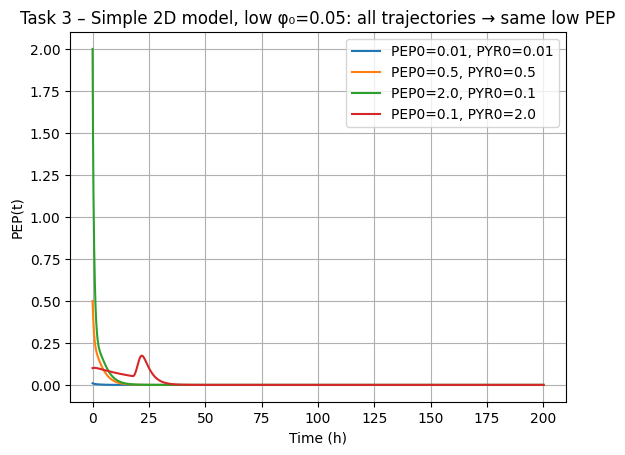

In [ ]:
from scipy.integrate import odeint

# -------- TASK 3, Part 1: Simple model, low energy φ0 --------

phi0_low = 0.05       # choose a low ATP/ADP baseline
r_example = 0.1       # pick one r, 0.1 is fine
d = d_fit

t_long = np.linspace(0, 200, 2000)

# Several initial conditions (including "dormant")
ICs = [
    [0.01, 0.01],   # very low PEP, PYR (dormant)
    [0.5, 0.5],
    [2.0, 0.1],
    [0.1, 2.0]
]

plt.clf()
for P0, Y0 in ICs:
    sol = odeint(simplified_model, [P0, Y0], t_long,
                 args=(r_example, d, phi0_low))
    PEP_t = sol[:, 0]
    plt.plot(t_long, PEP_t, label=f"PEP0={P0}, PYR0={Y0}")

plt.xlabel("Time (h)")
plt.ylabel("PEP(t)")
plt.title(f"Task 3 – Simple 2D model, low φ₀={phi0_low}: all trajectories → same low PEP")
plt.legend()
plt.grid(True)
plt.show()


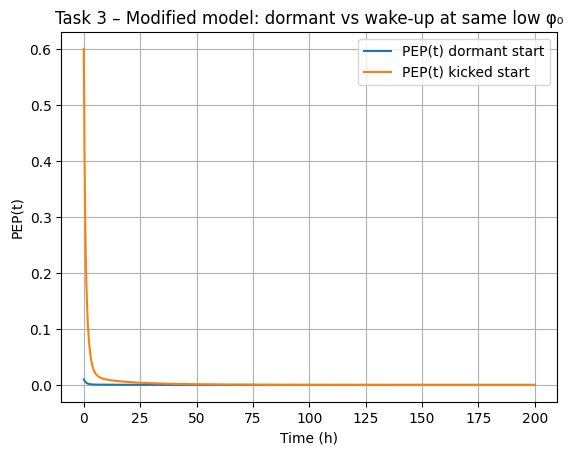

In [ ]:
# -------- TASK 3, Part 2: Modified 2D model with wake-up --------

def phi_P(PEP, phi0, alpha, K):
    """Energy status with positive feedback from PEP."""
    return phi0 + alpha * PEP / (K + PEP + 1e-12)

def modified_model(state, t, r, d, phi0, alpha, K):
    PEP, PYR = state
    phi = phi_P(PEP, phi0, alpha, K)

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)
    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)
    return [dPEP_dt, dPYR_dt]


phi0_low = 0.05   # same low energy baseline
alpha = 0.8       # strength of positive feedback
K = 0.5           # PEP scale
r_example = 0.1
d = d_fit

# Dormant initial condition
state_dorm = [0.01, 0.01]

# Slightly "kicked" initial condition
state_kick = [0.6, 0.1]

sol_dorm = odeint(modified_model, state_dorm, t_long,
                  args=(r_example, d, phi0_low, alpha, K))
sol_kick = odeint(modified_model, state_kick, t_long,
                  args=(r_example, d, phi0_low, alpha, K))

plt.clf()
plt.plot(t_long, sol_dorm[:, 0], label="PEP(t) dormant start")
plt.plot(t_long, sol_kick[:, 0], label="PEP(t) kicked start")
plt.xlabel("Time (h)")
plt.ylabel("PEP(t)")
plt.title("Task 3 – Modified model: dormant vs wake-up at same low φ₀")
plt.legend()
plt.grid(True)
plt.show()


## Extra (Jeroen)

/tmp/ipython-input-3412787173.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


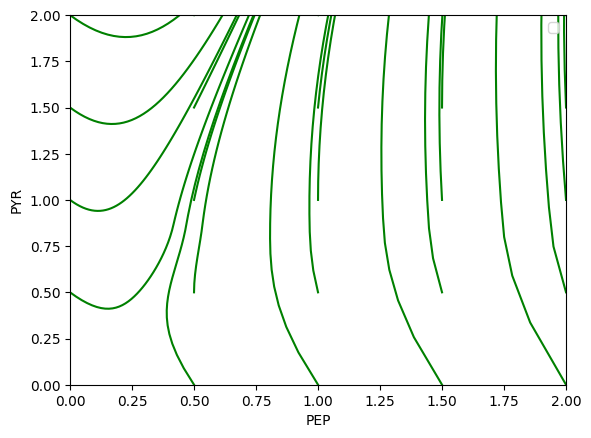

In [ ]:

# part of the second part
time = np.linspace(0, 100, 1001)

xlim = [0,2]
ylim = [0,2]

for PYRinit in np.linspace(0,2,5):
    for PEPinit in np.linspace(0,2,5):
        parameters = (r1, d_fit, phi0_fit) # r, d, phi0
        data = odeint(simplified_model, [PEPinit,PYRinit], time, args = parameters)
        plt.plot(data[:, 0],data[:, 1], color="green")

#pplane(simplified_model, parameters, xlim, ylim)
#nullclines(simplified_model, parameters, xlim, ylim)

plt.xlim(0,2)
plt.ylim(0,2)

plt.xlabel('PEP')
plt.ylabel('PYR')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(d_fit)
print(phi0_fit)
print(parameters)

1.084762e-09
0.136305
(0.1, 1.084762e-09, 0.136305)


/tmp/ipython-input-3057431756.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


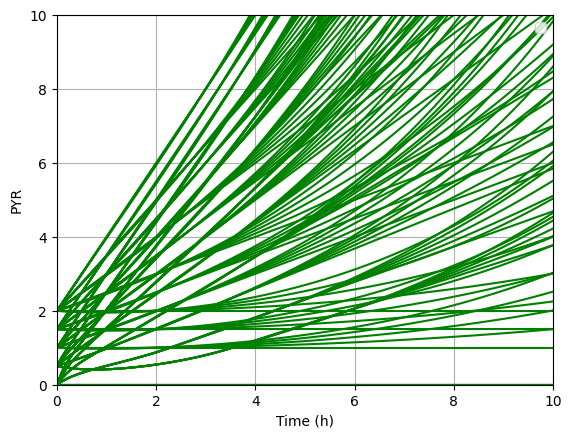

In [ ]:
time = np.linspace(0, 100, 1001)

for PYRinit in np.linspace(0,2,5):
    for PEPinit in np.linspace(0,2,5):
        for phi0 in np.linspace(0,0.05,5):
            parameters = (r1, d_fit, phi0) # r, d, phi0
            data = odeint(simplified_model, [PEPinit,PYRinit], time, args = parameters)
            plt.plot(time,data[:, 1], color="green")

# pplane(simplified_model, parameters, xlim, ylim)
#nullclines(ode1, pars1, xlim, ylim)

plt.xlim(0,10)
plt.ylim(0,10)

plt.xlabel('Time (h)')
plt.ylabel('PYR')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()